# Zeit & Location Analysen

In diesem Notebook testen wir zwei Hypothesen:

**H1:** Nachts sind Taxis schneller unterwegs als tagsüber  
**H2:** Airport-Fahrten folgen einer anderen Preisverteilung als normale Stadt-Fahrten

## Setup & Daten laden

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [2]:
# Daten laden
df = pd.read_csv('../data/Taxi_final_1M_clean.csv')
zones = pd.read_csv('../data/taxi_zones.csv')

# Zeitvariablen
df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour

print(f"Datensatz: {len(df):,} Fahrten")
df.head()

Datensatz: 967,493 Fahrten


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_datetime,pickup_hour
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,17.0,2023-02-06 18:31:28,18
1,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,11.2,2023-01-24 12:53:51,12
2,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,15.5,2023-02-04 22:58:49,22
3,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,15.5,2023-02-02 16:39:15,16
4,2023-02-15 21:08:32,2023-02-15 21:14:12,1.0,1.2,230,48,1,7.2,1.0,2.44,0.0,1.0,14.64,2.5,0.0,5.7,13.1,2023-02-15 21:08:32,21


---

## H1: Nachts sind Taxis schneller unterwegs

Hypothese: Die durchschnittliche Geschwindigkeit von Taxis ist nachts (22:00 - 6:00 Uhr) höher als tagsüber (6:00 - 22:00 Uhr).

Begründung: Nachts gibt es weniger Verkehr, wodurch Taxis schneller fahren können

Testmethode: Zweiseitiger t-Test 

### Daten vorbereiten: Tag vs. Nacht

In [ ]:
# Tag/Nacht Kategorisierung
df['time_period'] = df['pickup_hour'].apply(
    lambda x: 'Nacht (22-6h)' if (x >= 22 or x < 6) else 'Tag (6-22h)'
)

# Gruppen erstellen
day_speed = df[df['time_period'] == 'Tag (6-22h)']['average_speed']
night_speed = df[df['time_period'] == 'Nacht (22-6h)']['average_speed']

print("Deskriptive Statistik:")
print(f"\n{'Tag (6-22h)':15s}: n={len(day_speed):>7,}  Mean={day_speed.mean():>6.2f} km/h  Median={day_speed.median():>6.2f} km/h  Std={day_speed.std():>5.2f}")
print(f"{'Nacht (22-6h)':15s}: n={len(night_speed):>7,}  Mean={night_speed.mean():>6.2f} km/h  Median={night_speed.median():>6.2f} km/h  Std={night_speed.std():>5.2f}")
print(f"\nDifferenz: {night_speed.mean() - day_speed.mean():.2f} km/h")

Deskriptive Statistik:

Tag (6-22h)    : n=801,669  Mean= 17.28 km/h  Median= 14.80 km/h  Std= 9.81
Nacht (22-6h)  : n=165,824  Mean= 23.40 km/h  Median= 20.00 km/h  Std=12.44

Differenz: 6.11 km/h


### Visualisierung: Geschwindigkeitsverteilung

/tmp/ipykernel_803/1148331641.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_box, labels=['Tag (6-22h)', 'Nacht (22-6h)'], patch_artist=True, widths=0.6)


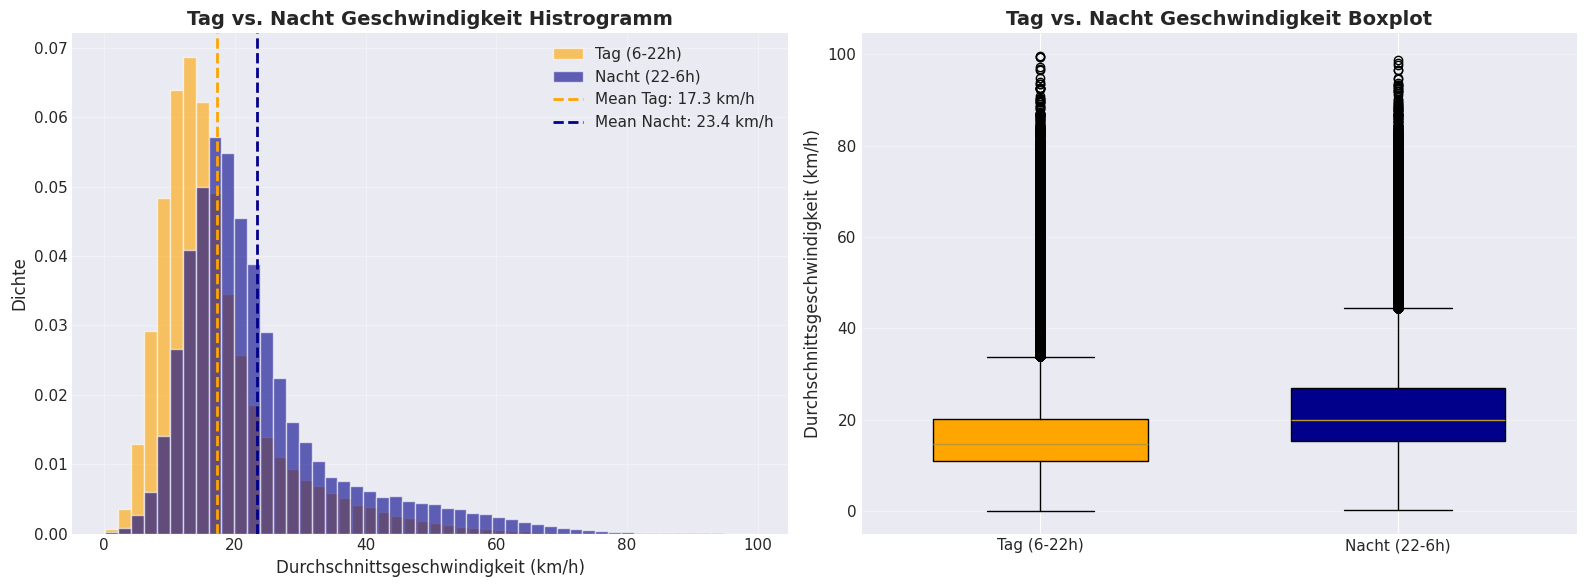

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramm mit Überlagerung
axes[0].hist(day_speed, bins=50, alpha=0.6, label='Tag (6-22h)', color='orange', density=True, edgecolor='white')
axes[0].hist(night_speed, bins=50, alpha=0.6, label='Nacht (22-6h)', color='darkblue', density=True, edgecolor='white')
axes[0].axvline(day_speed.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean Tag: {day_speed.mean():.1f} km/h')
axes[0].axvline(night_speed.mean(), color='darkblue', linestyle='--', linewidth=2, label=f'Mean Nacht: {night_speed.mean():.1f} km/h')
axes[0].set_xlabel('Durchschnittsgeschwindigkeit (km/h)', fontsize=12)
axes[0].set_ylabel('Dichte', fontsize=12)
axes[0].set_title('Tag vs. Nacht Geschwindigkeit Histrogramm', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
data_box = [day_speed, night_speed]
bp = axes[1].boxplot(data_box, labels=['Tag (6-22h)', 'Nacht (22-6h)'], patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('orange')
bp['boxes'][1].set_facecolor('darkblue')
axes[1].set_ylabel('Durchschnittsgeschwindigkeit (km/h)', fontsize=12)
axes[1].set_title('Tag vs. Nacht Geschwindigkeit Boxplot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Geschwindigkeit nach Stunde

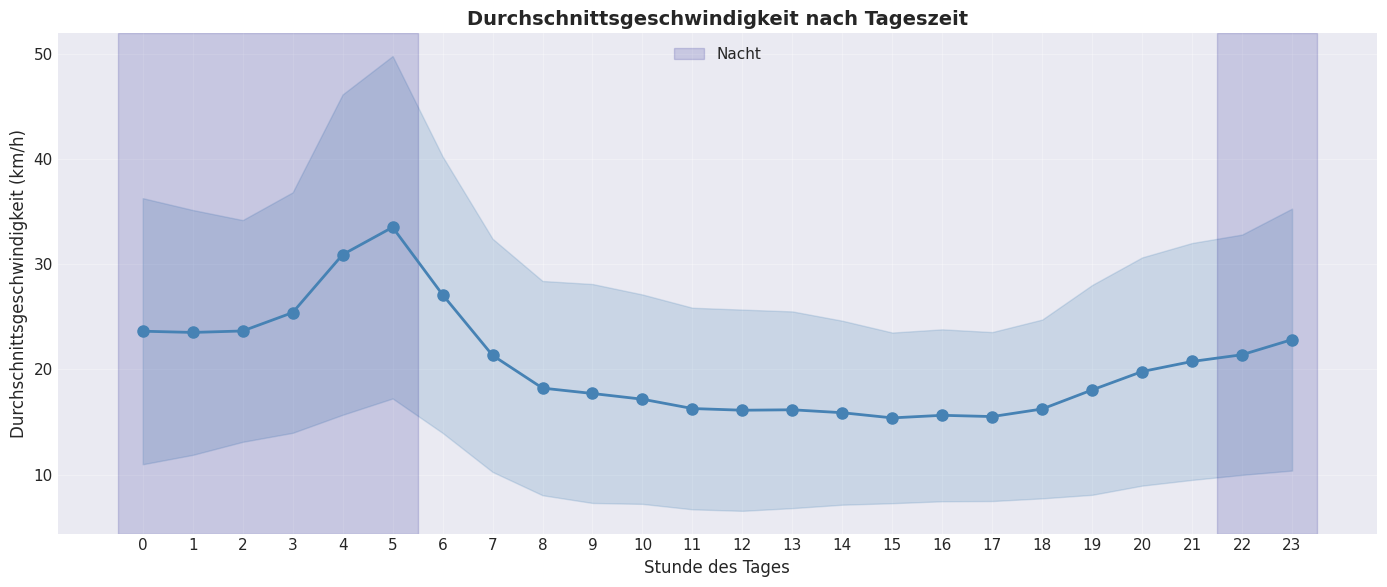


Top 5 schnellste Stunden:
   pickup_hour       mean
5            5  33.519340
4            4  30.917881
6            6  27.109028
3            3  25.404172
2            2  23.656075


In [5]:
# Durchschnittsgeschwindigkeit pro Stunde
hourly_speed = df.groupby('pickup_hour')['average_speed'].agg(['mean', 'median', 'std']).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(hourly_speed['pickup_hour'], hourly_speed['mean'], marker='o', linewidth=2, markersize=8, color='steelblue')
plt.fill_between(hourly_speed['pickup_hour'], 
                 hourly_speed['mean'] - hourly_speed['std'], 
                 hourly_speed['mean'] + hourly_speed['std'], 
                 alpha=0.2, color='steelblue')

# Nacht-Bereich markieren
plt.axvspan(-0.5, 5.5, alpha=0.15, color='navy', label='Nacht')
plt.axvspan(21.5, 23.5, alpha=0.15, color='navy')

plt.xlabel('Stunde des Tages', fontsize=12)
plt.ylabel('Durchschnittsgeschwindigkeit (km/h)', fontsize=12)
plt.title('Durchschnittsgeschwindigkeit nach Tageszeit', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 schnellste Stunden:")
print(hourly_speed.nlargest(5, 'mean')[['pickup_hour', 'mean']])

### Statistischer Test: t-Test

In [16]:
statistic, p_value = ttest_ind(night_speed, day_speed, equal_var=False, alternative='greater')

print(f"H0: mu_Nacht <= mu_Tag (Nacht-Geschwindigkeit ist nicht höher)")
print(f"H1: mu_Nacht > mu_Tag (Nacht-Geschwindigkeit ist höher) [einseitig]")
print(f"\nt-Statistik: {statistic:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Signifikanzniveau: alpha = 0.05")
print(f"\nStichprobengrossen:")
print(f"  Tag:   n = {len(day_speed):,}")
print(f"  Nacht: n = {len(night_speed):,}")
print("="*70)

if p_value < 0.05:
    print("Resultat: H0 wird verworfen (p < 0.05)")
    print(f"Taxis sind nachts signifikant schneller")
    print(f"Nacht: {night_speed.mean():.2f} km/h vs. Tag: {day_speed.mean():.2f} km/h")
    print(f"Differenz: +{night_speed.mean() - day_speed.mean():.2f} km/h")
else:
    print("Resultat: H0 wird nicht verworfen (p >= 0.05)")
    print("Kein signifikanter Unterschied nachweisbar")
print("="*70)

H0: mu_Nacht <= mu_Tag (Nacht-Geschwindigkeit ist nicht höher)
H1: mu_Nacht > mu_Tag (Nacht-Geschwindigkeit ist höher) [einseitig]

t-Statistik: 188.3000
p-value: 0.000000
Signifikanzniveau: alpha = 0.05

Stichprobengrossen:
  Tag:   n = 801,669
  Nacht: n = 165,824
Resultat: H0 wird verworfen (p < 0.05)
Taxis sind nachts signifikant schneller
Nacht: 23.40 km/h vs. Tag: 17.28 km/h
Differenz: +6.11 km/h


## H2: Airport-Fahrten haben eine andere Preisverteilung

Hypothese: Fahrten zu/von Flughäfen (JFK, LaGuardia, Newark) haben eine andere Fahrpreis-Verteilung als normale Stadt-Fahrten.

Begründung: Flughafen-Fahrten haben oft:
- Flat Rates
- Längere Distanzen
- Andere Preisstruktur

Testmethode: t-Test für Mittelwertvergleich + deskriptive Statistik

### Airport-Locations identifizieren

In [7]:
# Airport-Zonen identifizieren
print("Verfügbare Airport-Zonen:")
airport_zones = zones[zones['Zone'].str.contains('Airport|JFK|LaGuardia|Newark', case=False, na=False)]
print(airport_zones[['LocationID', 'Borough', 'Zone']])

# Airport Location IDs
airport_ids = airport_zones['LocationID'].tolist()
print(f"\nAirport Location IDs: {airport_ids}")

# Fahrten kategorisieren
df['is_airport_trip'] = (df['PULocationID'].isin(airport_ids)) | (df['DOLocationID'].isin(airport_ids))

# Statistik
n_airport = df['is_airport_trip'].sum()
n_city = (~df['is_airport_trip']).sum()
print(f"\nAnzahl Fahrten:")
print(f"  Airport-Fahrten: {n_airport:,} ({n_airport/len(df)*100:.1f}%)")
print(f"  Stadt-Fahrten:   {n_city:,} ({n_city/len(df)*100:.1f}%)")

Verfügbare Airport-Zonen:
     LocationID Borough               Zone
0             1     EWR     Newark Airport
131         132  Queens        JFK Airport
137         138  Queens  LaGuardia Airport

Airport Location IDs: [1, 132, 138]

Anzahl Fahrten:
  Airport-Fahrten: 106,786 (11.0%)
  Stadt-Fahrten:   860,707 (89.0%)


### Deskriptive Statistik: Airport vs. Stadt

In [13]:
# Fahrpreise filtern (realistischer Bereich)
df_fare = df[(df['fare_amount'] > 0) & (df['fare_amount'] <= 200)].copy()

# Gruppen erstellen
airport_fares = df_fare[df_fare['is_airport_trip']]['fare_amount']
city_fares = df_fare[~df_fare['is_airport_trip']]['fare_amount']

print("Deskriptive Statistik - Fahrpreise:")
print(f"\n{'Airport-Fahrten':20s}: n={len(airport_fares):>7,}  Mean=${airport_fares.mean():>6.2f}  Median=${airport_fares.median():>6.2f}  Std=${airport_fares.std():>5.2f}")
print(f"{'Stadt-Fahrten':20s}: n={len(city_fares):>7,}  Mean=${city_fares.mean():>6.2f}  Median=${city_fares.median():>6.2f}  Std=${city_fares.std():>5.2f}")
print(f"\nDifferenz: ${airport_fares.mean() - city_fares.mean():.2f}")

# Weitere Metriken
print(f"\n{'Metrik':25s} {'Airport':>15s} {'Stadt':>15s}")
print("-"*70)
print(f"{'25. Perzentil':25s} ${airport_fares.quantile(0.25):>14.2f} ${city_fares.quantile(0.25):>14.2f}")
print(f"{'75. Perzentil':25s} ${airport_fares.quantile(0.75):>14.2f} ${city_fares.quantile(0.75):>14.2f}")
print(f"{'IQR':25s} ${airport_fares.quantile(0.75) - airport_fares.quantile(0.25):>14.2f} ${city_fares.quantile(0.75) - city_fares.quantile(0.25):>14.2f}")

Deskriptive Statistik - Fahrpreise:

Airport-Fahrten     : n=106,580  Mean=$ 56.17  Median=$ 56.90  Std=$20.73
Stadt-Fahrten       : n=860,638  Mean=$ 15.13  Median=$ 12.80  Std=$ 9.72

Differenz: $41.03

Metrik                            Airport           Stadt
----------------------------------------------------------------------
25. Perzentil             $         41.50 $          8.60
75. Perzentil             $         70.00 $         18.40
IQR                       $         28.50 $          9.80


### Visualisierung: Preisverteilung Airport vs. Stadt

/tmp/ipykernel_803/2213948511.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_box, labels=['Stadt-Fahrten', 'Airport-Fahrten'], patch_artist=True, widths=0.6)


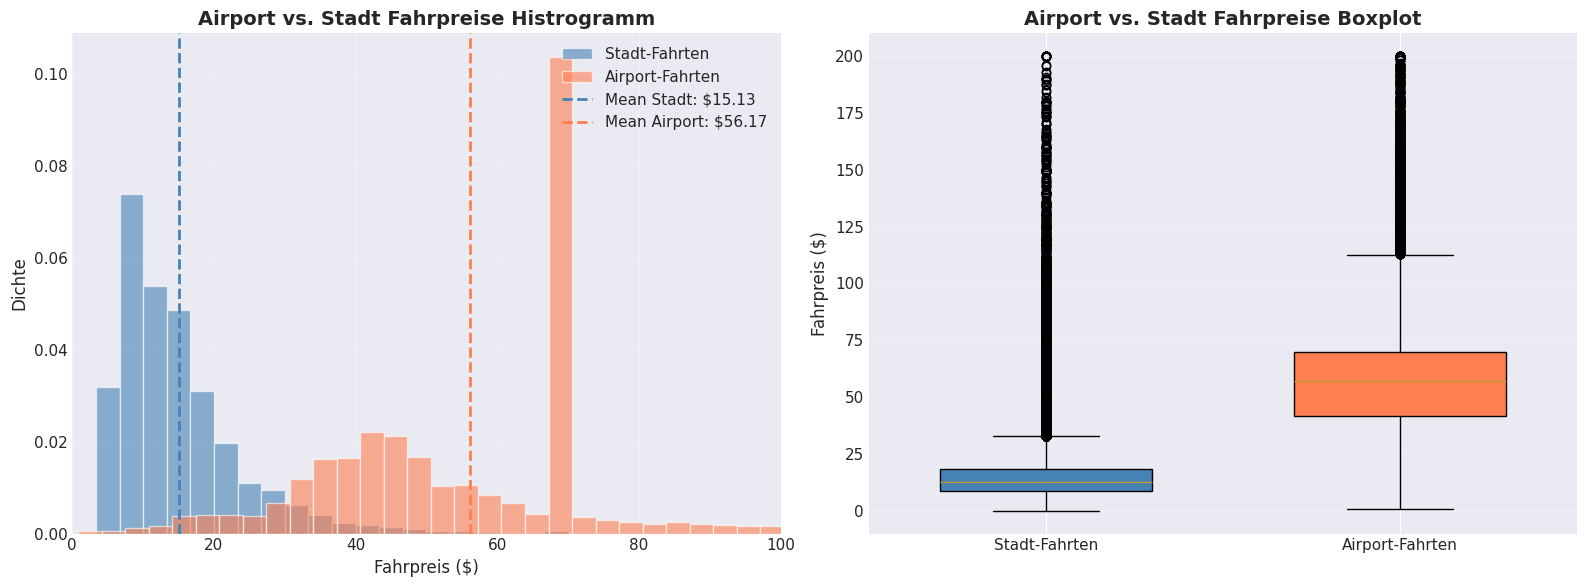

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramm mit Überlagerung
axes[0].hist(city_fares, bins=60, alpha=0.6, label='Stadt-Fahrten', color='steelblue', density=True, edgecolor='white')
axes[0].hist(airport_fares, bins=60, alpha=0.6, label='Airport-Fahrten', color='coral', density=True, edgecolor='white')
axes[0].axvline(city_fares.mean(), color='steelblue', linestyle='--', linewidth=2, label=f'Mean Stadt: ${city_fares.mean():.2f}')
axes[0].axvline(airport_fares.mean(), color='coral', linestyle='--', linewidth=2, label=f'Mean Airport: ${airport_fares.mean():.2f}')
axes[0].set_xlabel('Fahrpreis ($)', fontsize=12)
axes[0].set_ylabel('Dichte', fontsize=12)
axes[0].set_title('Airport vs. Stadt Fahrpreise Histrogramm', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 100)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
data_box = [city_fares, airport_fares]
bp = axes[1].boxplot(data_box, labels=['Stadt-Fahrten', 'Airport-Fahrten'], patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('coral')
axes[1].set_ylabel('Fahrpreis ($)', fontsize=12)
axes[1].set_title('Airport vs. Stadt Fahrpreise Boxplot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### t-Test für Mittelwertvergleich

In [15]:
statistic, p_value = ttest_ind(airport_fares, city_fares, equal_var=False)

print(f"H0: mu_Airport = mu_Stadt (Mittelwerte sind gleich)")
print(f"H1: mu_Airport != mu_Stadt (Mittelwerte sind unterschiedlich) [zweiseitig]")
print(f"\nt-Statistik: {statistic:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Signifikanzniveau: alpha = 0.05")
print(f"\nStichprobengrössen:")
print(f"  Airport: n = {len(airport_fares):,}")
print(f"  Stadt: n = {len(city_fares):,}")
print("="*70)

if p_value < 0.05:
    print("Resultat: H0 wird verworfen (p < 0.05)")
    print(f"Airport- und Stadt-Fahrten haben signifikant unterschiedliche Preise")
    print(f"Airport: ${airport_fares.mean():.2f} vs. Stadt: ${city_fares.mean():.2f}")
    print(f"Differenz: ${airport_fares.mean() - city_fares.mean():.2f}")
else:
    print("Resultat: H0 wird nicht verworfen (p >= 0.05)")
    print("Kein signifikanter Unterschied in den Mittelwerten nachweisbar")

H0: mu_Airport = mu_Stadt (Mittelwerte sind gleich)
H1: mu_Airport != mu_Stadt (Mittelwerte sind unterschiedlich) [zweiseitig]

t-Statistik: 637.6241
p-value: 0.000000
Signifikanzniveau: alpha = 0.05

Stichprobengrössen:
  Airport: n = 106,580
  Stadt: n = 860,638
Resultat: H0 wird verworfen (p < 0.05)
Airport- und Stadt-Fahrten haben signifikant unterschiedliche Preise
Airport: $56.17 vs. Stadt: $15.13
Differenz: $41.03


## Zusammenfassung & Fazit

### H1: Nachts sind Taxis schneller unterwegs

Ergebnis: Hypothese bestätigt  
- Nachts fahren Taxis signifikant schneller als tagsüber
- Grund dafür ist wahrscheinlich weniger Verkehr in den Nachtstunden (22:00-6:00 Uhr)

### H2: Airport-Fahrten haben andere Preisverteilung

Ergebnis: Hypothese bestätigt  
- Airport-Fahrten haben signifikant höhere Durchschnittspreise
- Grund: Längere Distanzen und Flat Rates
- Deutlich erkennbare unterschiedliche Verteilungsstruktur